<a href="https://colab.research.google.com/github/cckmwong-data/youtube_sentiment_analysis/blob/main/youtube_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SENTIMENT ANALYSIS USING LONG SHORT-TERM MEMORY (LSTM)**

##**Problem Statement**
In the age of social media, understanding public sentiment has become essential for businesses, organizations, and researchers. Twitter, as one of the largest platforms for public expression, offers a vast and valuable source of data for sentiment analysis. The goal of this project is to develop a machine learning model capable of accurately classifying the sentiment of social media comments as either positive or negative. This analysis can provide actionable insights to help organizations tailor their products and marketing strategies, improve customer service, and ultimately enhance user satisfaction.

To make these insights more accessible, the trained model will be integrated into an interactive Streamlit [application](https://huggingface.co/spaces/cckmwong/youtube_sentiment) and deployed on Hugging Face. Users will simply copy and paste the URL of a YouTube video to analyze and visualize the sentiment of its comments through various charts and tables, enabling data-driven decision-making in an intuitive and user-friendly way.

##**Workflow Summary**

This study utilizes the [Sentiment140 dataset](https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip), which contains 1.6 million pre-labeled tweets, annotated for sentiment polarity. The dataset includes metadata such as tweet text, user information, and sentiment labels (0 = negative, 4 = positive).

1. Import required libraries
2. Download and unzip Sentiment140 file
3. Due to the large size of the database, a sample data of 500K rows of positive (250K) and negative (250K) comments are used
4. Preprocess and clean the tweet text to remove noise such as URLs, mentions, and non-alphabetic characters
5. Split the data into training and test data with tokenization
6. Train the LSTM model with pre-trained GloVe as the embeddings layer
7. Evaluate the model and compare its performance with traditional approaches, TextBlob and VADER
8. Save the model, tokenizer and max length of sequence for Streamlit app deployment on Hugging Face
9. Due to the daily quota limitations of the YouTube Data API, the [demo application](https://huggingface.co/spaces/cckmwong/youtube_sentiment_demo)  uses preloaded YouTube comments and metadata. This allows users to explore data-driven insights and visualize sentiment analysis through interactive charts and tables. In the full implementation (as shown in the image below), the application enables users to paste a YouTube link directly for real-time data analysis.
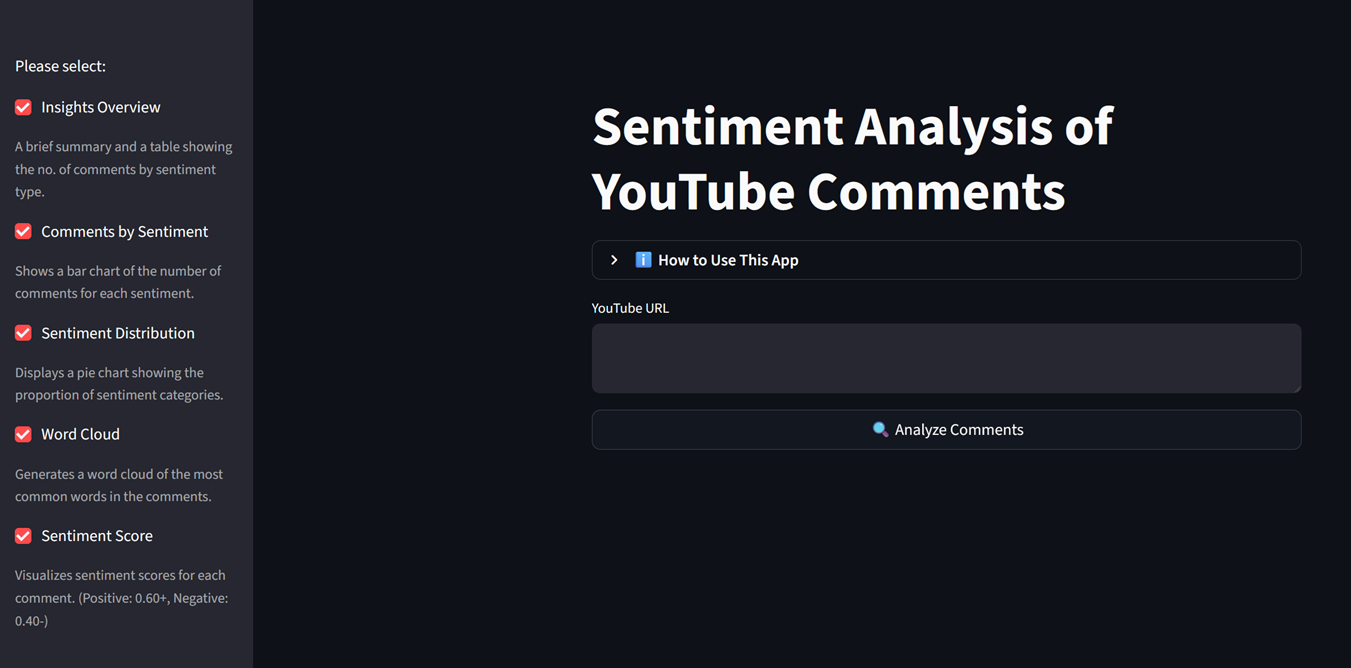

#(1) Import Libaries

In [ ]:
# import key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

import zipfile
import io
import urllib.request
import html.parser
import html
import joblib
from sklearn.metrics import accuracy_score

In [ ]:
# Download libraries for processing and analyzing text
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag

from nltk.tokenize import TweetTokenizer

nltk.download("stopwords")
stopwords.words('english')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.9 MB/s eta 0:00:00


In [ ]:
# Import TextBlob and VADER libraries for comparing the LSTM model performance
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score

#(2) Exploratory Data Analysis
After downloading and unzipping the dataset, we prepare the data for sentiment analysis by extracting useful columns, checking any null values and exmaining the features and data distribution.

In [ ]:
# URL of Sentiment140 zip file
url = 'https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'

# Download the zip file
response = urllib.request.urlopen(url)
zip_data = response.read()

# Open the zip file
with zipfile.ZipFile(io.BytesIO(zip_data)) as z:
    # List files in the archive
    print("Files in ZIP:", z.namelist())

    # Extract 'training.1600000.processed.noemoticon.csv'
    with z.open('training.1600000.processed.noemoticon.csv') as f:
        # Load the file into pandas DataFrame
        df = pd.read_csv(f, encoding='latin-1', header=None)

print("DataFrame loaded with shape:", df.shape)

Files in ZIP: ['testdata.manual.2009.06.14.csv', 'training.1600000.processed.noemoticon.csv']
DataFrame loaded with shape: (1600000, 6)


In [ ]:
# add the column names
df.columns = ["sentiment", "time", "date", "query", "username", "text"]

In [ ]:
df

,sentiment,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
df.shape

(1600000, 6)

In [ ]:
# only extract the columns of sentiment and text
df = df[['sentiment', 'text']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [ ]:
# check if any null values
df.isnull().sum()

,0
sentiment,0
text,0


In [ ]:
# change the positive sentiment label from 4 to 1; negative sentiment label remains to be 0
df.loc[df['sentiment'] == 4, 'sentiment'] = 1

In [ ]:
df

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
# check the unique values of sentiment
df['sentiment'].unique()

array([0, 1])

<BarContainer object of 2 artists>

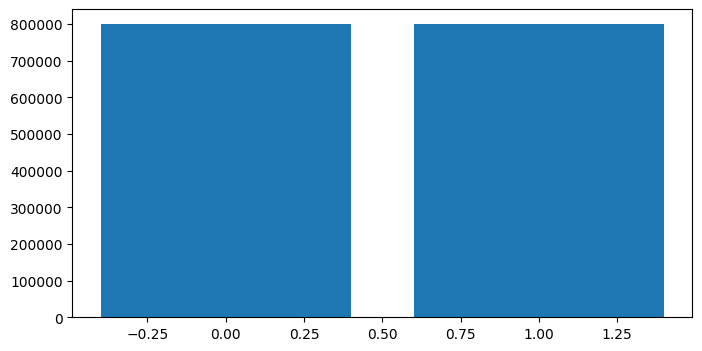

In [ ]:
# show the distribution of positive and negative comments
distribution = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(distribution.index, distribution.values)

#(3) Data Cleaing of Tweet Text
Due to the large size of the dataset and the lengthy processing time required, a random subset of 500,000 tweets (250K from positive sentiment and 250K from negative sentiment) were used for analysis. The data cleaning process included converting all text to lowercase and removing HTML tags, Twitter mentions, URLs, email addresses, and stop words to ensure cleaner and more consistent input for analysis. The cleaned text is in the form of individal tokenized words.

In [ ]:
# subset 500k rows of positive and negative comments
df_postive = df[df['sentiment'] == 1].sample(n=250000, random_state=42)
df_negative = df[df['sentiment'] == 0].sample(n=250000, random_state=42)
data = pd.concat([df_postive, df_negative])

In [ ]:
# function to remove URLs and emails
def remove_mention_url_email(text):
    # remove mentions, URLs, and emails by replacing these patterns by space
    # and then change to lower case
    text = re.sub(r"@\S+|https?:\S+|http?:\S+|\S+@\S+", ' ', str(text).lower())

    # remove extra spaces
    return text.strip()

In [ ]:
# function to reove the HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    text = re.sub(clean, '', text)

    # Decode HTML entities
    return html.unescape(text)

In [ ]:
# function to remove stopwords
def remove_stopwords(words):
    tokens = []
    stop_words = stopwords.words('english')

    # only keep those words which are not stop words with length greater than 2
    for word in words:
      if len(word) >= 2 and word not in stop_words:
        tokens.append(word)

    return tokens

In [ ]:
# function to convert nltk POS (part of speech) tag to WordNet POS tag
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# change to lemmatized text with the consideration of the POS
def lemmatize_text(words):
    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(words) # get NLTK’s pos_tag
    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag))
        for word, pos_tag in pos_tags
    ]
    return lemmatized_words

In [ ]:
# remove punctuation and other non-alphabetic characters
def remove_punc(text):
    # replace anything that is NOT a lowercase letter or space to space
    text = re.sub(r"[^a-z\s]", ' ', text)
    return text

In [ ]:
# Data cleaning of tweet text

data = data.copy()
tokenizer = TweetTokenizer() # Split tweet text into tokens

data['text'] = data['text'].str.lower() # convert the text to lower case
data['cleaned_text'] = data['text'].apply(remove_html_tags) # remove html tags
data['cleaned_text'] = data['cleaned_text'].apply(remove_mention_url_email) # remove twitter mentions, url, email
data['cleaned_text'] = data['cleaned_text'].apply(remove_html_tags) # remove html tags
data['cleaned_text'] = data['cleaned_text'].apply(remove_punc) # remove punctuations and symbols
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: lemmatize_text(tokenizer.tokenize(x))) # tokenize the column and then convert to lemmatized text
data['cleaned_text'] = data['cleaned_text'].apply(remove_stopwords) # remove stop words

In [ ]:
data = data.reset_index(drop=True) # reset index
data

,sentiment,text,cleaned_text
0,1,is lookin 4ward to a long weekend really dont...,"[lookin, ward, long, weekend, really, dont, wa..."
1,1,#myweakness is music and i live to meet the p...,"[myweakness, music, live, meet, people, make]"
2,1,figured out the internet on my new ipod,"[figure, internet, new, ipod]"
3,1,@hillsongunited can't wait to worship with you...,"[wait, worship, guy, tonight, much, fun]"
4,1,@sillybeggar congrats james !! i'm sure the bo...,"[congrats, jam, sure, book, go, huge, success]"
...,...,...,...
499995,0,@kawilson9 but. it's will tippin.,[tippin]
499996,0,@leeolim but wai? wai in valenzuela? i can't ...,"[wai, wai, valenzuela, wait, meet]"
499997,0,ouchhhhh swollen ankle.,"[ouchhhhh, swollen, ankle]"
499998,0,mcdo never called.. do you think it's coming?,"[mcdo, never, call, think, come]"


In [ ]:
# find the max number of tokenized words of any string
max_length = 0

for i in data['cleaned_text']:
  length = len(i)
  if (length > max_length):
    max_length = length

print(max_length)

30


In [ ]:
list_of_words = []

# copy and count every single word of the cleaned tweet texts
for i in data['cleaned_text']:
    for j in i:
        list_of_words.append(j)

# Obtain the total words present in the dataset
total_words = len(list_of_words)
total_words

3392059

#(4) Split the Data into Training and Test Data
We split the cleaned dataset into training and testing subsets for model development and evaluation. The feature variable X contains the cleaned tweet text, while y holds the corresponding sentiment labels (i.e. positive or negative). The data is divided so that 80% is used for training the model (X_train, y_train) and 20% is reserved for testing (X_test, y_test). This ensures that the model is trained on one portion of the data and evaluated on unseen data, allowing for an objective assessment of its performance and generalization ability.

In [ ]:
# split the data into test and training data
X = data['cleaned_text']
y = data['sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
X_train.shape # 400K rows for training data

(400000,)

In [ ]:
X_test.shape # 100K rows for test data

(100000,)

In [ ]:
# test data including  X_test and y_test will be useful for measuring the accuracy of the sentiment predictions generated by VADER and TextBlob
test_data = pd.concat([X_test, y_test], axis=1)
test_data

,cleaned_text,sentiment
461877,"[gutted, cornwall]",0
135332,"[cool, sure, work, try]",1
322278,"[lose, voice, almost]",0
296945,[],0
215650,"[saw, report, news, kanina]",1
...,...,...
96833,"[plan, today, inaugural, yegbiker, tweetup, ye...",1
110931,"[ok, win, let]",1
475901,"[yea, something, bit, outside, breakin]",0
460271,"[ello, mona, teeth, hurt]",0


#(5) Tokenization of the Training and Test Data
We prepare the tweet text data for use in deep learning models by converting it into numerical form. It first creates a Tokenizer that learns all unique words from the training data (X_train) and assigns each word a unique integer index, stored in the word_index dictionary. The tokenizer then vectorize each tweet in both the training and test sets into sequences of these integer indices.

Since neural networks require inputs of consistent length, the sequences are padded to a fixed size defined by max_length (i.e. the maximum number of tokenized words amongst all the strings), ensuring that all tweets have the same number of tokens. This process standardizes the text data so it can be efficiently fed into the LSTM models for sentiment classification.

In [ ]:
# Create a tokenizers for vectorizing text (integer sequence)
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(X_train)

# word_index is a dictionary that maps each unique word from X_train to a
# unique integer index
word_index = tokenizer2.word_index
print(word_index)

{'get': 1, 'go': 2, 'day': 3, 'good': 4, 'work': 5, 'like': 6, 'love': 7, 'today': 8, 'time': 9, 'think': 10, 'lol': 11, 'know': 12, 'want': 13, 'back': 14, 'see': 15, 'make': 16, 'one': 17, 'miss': 18, 'well': 19, 'im': 20, 'really': 21, 'feel': 22, 'night': 23, 'come': 24, 'need': 25, 'still': 26, 'watch': 27, 'new': 28, 'home': 29, 'look': 30, 'oh': 31, 'thanks': 32, 'much': 33, 'last': 34, 'say': 35, 'twitter': 36, 'morning': 37, 'hope': 38, 'great': 39, 'tomorrow': 40, 'wish': 41, 'bad': 42, 'sleep': 43, 'take': 44, 'wait': 45, 'haha': 46, 'sad': 47, 'fun': 48, 'week': 49, 'right': 50, 'happy': 51, 'try': 52, 'would': 53, 'thing': 54, 'sorry': 55, 'tonight': 56, 'friend': 57, 'way': 58, 'find': 59, 'though': 60, 'nice': 61, 'gonna': 62, 'leave': 63, 'yeah': 64, 'start': 65, 'bed': 66, 'tweet': 67, 'could': 68, 'people': 69, 'hour': 70, 'school': 71, 'hate': 72, 'show': 73, 'win': 74, 'even': 75, 'follow': 76, 'weekend': 77, 'thank': 78, 'guy': 79, 'hey': 80, 'yes': 81, 'let': 82, 

In [ ]:
# Vectorize each row of data into sequence of numbers
train_sequences = tokenizer2.texts_to_sequences(X_train)
test_sequences = tokenizer2.texts_to_sequences(X_test)

In [ ]:
# Add padding zeros to training and test data
# to make all the sequences to be the same length
padded_train = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

#(6) GloVe Vectors
We load pre-trained GloVe word embeddings and create an embedding matrix to represent words from the training data as numerical vectors. It first reads the glove.6B.300d.txt file, which contains 300-dimensional vector representations of words trained on a large text corpus. Each line is split so that the first element is the word and the rest are its embedding values, which are stored in the embedding_index dictionary.
For every word in the training data’s vocabulary, it looks up the corresponding pre-trained vector from GloVe; if found, the vector is added to the embedding matrix. This matrix is later used in neural network models to provide meaningful semantic representations of words, helping the model better understand relationships and context within the text.

In [ ]:
# mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load GloVe vectors
embedding_index = {}

# read the glove.6B.300d.txt file stored at Googel Drive
with open('/content/drive/MyDrive/glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        # splits the string into a list of words/numbers based on spaces
        values = line.strip().split()
        # the first value is the key (i.e. the word)
        word = values[0]
        # extract the word embeddings of the word
        coeffs = np.asarray(values[1:], dtype='float32')
        # Stores the word as the key and its embedding vector as the value in the dictionary embedding_index
        embedding_index[word] = coeffs

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

Loaded 400000 word vectors from GloVe.


In [ ]:
# finding the total no. of unique words of X_train
vocab_size = len(tokenizer2.word_index) + 1 # plus 1 for an placeholder (index 0) for padding or out-of-vocabulary tokens
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 107194


In [ ]:
# Creates a matrix of zeros with shape (vocab_size, 300)
embedding_matrix = np.zeros((vocab_size, 300))
found = 0

# Check if there is any pre-trained vector for every distinct word of X_train
# if so, store it in embedding_maxtrix and count the words found
for word, i in word_index.items(): # for every unique word in X_train
    # safety check for out-of-bounds indices which may otherwise skip the rest of the codes and start another pair of i
    if i >= vocab_size:
        continue
    embedding_vector = embedding_index.get(word) # try to get the pre-trained vectors for a word in X_train
    if embedding_vector is not None: # if the word appears in GloVe
        embedding_matrix[i] = embedding_vector # store the pre-trained 300-D
        found += 1 # update the counter when the word is matched in GloVe

print(f"Found embeddings for {found} words out of {vocab_size}.")


Found embeddings for 50035 words out of 107194.


#(7) LSTM Model
Here we build a Bidirectional LSTM (Long Short-Term Memory) network using pre-trained GloVe embeddings. Bidirectional LSTM layer captures contextual information from both forward and backward directions of the text, followed by GlobalMaxPooling1D, which condenses the sequence outputs by selecting the most significant features. The output layer uses a sigmoid activation to produce a binary sentiment prediction. During training, early stopping prevents overfitting by halting training when validation loss stops improving, and class weights balance the impact of positive and negative samples. Finally, we plot the training accuracy and validation accuracy curves which show solid results with limited overfitting.

In [ ]:
from tensorflow.keras.layers import GlobalMaxPooling1D

# function for the LSTM model
def tensorflow_based_model(embedding_matrix, vocab_size, max_length):
    # inputs is a padded sequence of token IDs
    inputs = Input(name='inputs', shape=(max_length,))

    # Embedding layer: use pre-trained GloVe embeddings
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_matrix.shape[1], # dimension = 300
        weights=[embedding_matrix], # load GloVe vectors
        trainable=True, # Set to True for fine-tuning
        mask_zero=False
    )(inputs)

    x = Dropout(0.3)(embedding_layer) # set drop out to 0.3 to prevent overfitting

    # Bi-directional - Learns from the input sequence in both
    # forward and backward directions
    x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))(x)

    # collapse every LSTM output into one single vector by choosing the max value (strongest feature)
    x = GlobalMaxPooling1D()(x)

    # Dense layer
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)

    # Drop out to prevent overfitting
    x = Dropout(0.2)(x)

    # Output layer: A probability for binary sentiment prediction
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = tensorflow_based_model(embedding_matrix, vocab_size, max_length)

# configure the model on how to measure errors and how to update weight (learn from errors)
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
from sklearn.utils import class_weight

from tensorflow.keras.callbacks import EarlyStopping

# If the model doesn’t improve for 2 consecutive epochs, it stops training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', # for model robustness in case of future imbalanced dataset
    classes=np.unique(y_train),
    y=y_train
)

# fit with weights
history = model.fit(
    padded_train, y_train,
    validation_split=0.1, # 10% of the training data as validation
    batch_size=80, # Train in mini-batches of 80 samples
    epochs=20, # training up to 20 times
    callbacks=[early_stop], # Stop if validation loss stops improving
    class_weight=dict(enumerate(class_weights))
)


Epoch 1/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 545s 119ms/step - accuracy: 0.7231 - loss: 0.5923 - val_accuracy: 0.7645 - val_loss: 0.4983
Epoch 2/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 550s 122ms/step - accuracy: 0.7625 - loss: 0.4937 - val_accuracy: 0.7711 - val_loss: 0.4805
Epoch 3/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 538s 117ms/step - accuracy: 0.7719 - loss: 0.4821 - val_accuracy: 0.7720 - val_loss: 0.4824
Epoch 4/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 574s 120ms/step - accuracy: 0.7780 - loss: 0.4716 - val_accuracy: 0.7749 - val_loss: 0.4725
Epoch 5/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 535s 119ms/step - accuracy: 0.7834 - loss: 0.4630 - val_accuracy: 0.7789 - val_loss: 0.4708
Epoch 6/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 535s 119ms/step - accuracy: 0.7897 - loss: 0.4540 - val_accuracy: 0.7811 - val_loss: 0.4670
Epoch 7/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 535s 119ms/step - accuracy: 0.7964 - loss: 0.4421 - val_accuracy: 0.7793 - val_loss: 0.4697
Epoch 8/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 537s 119ms/step - ac

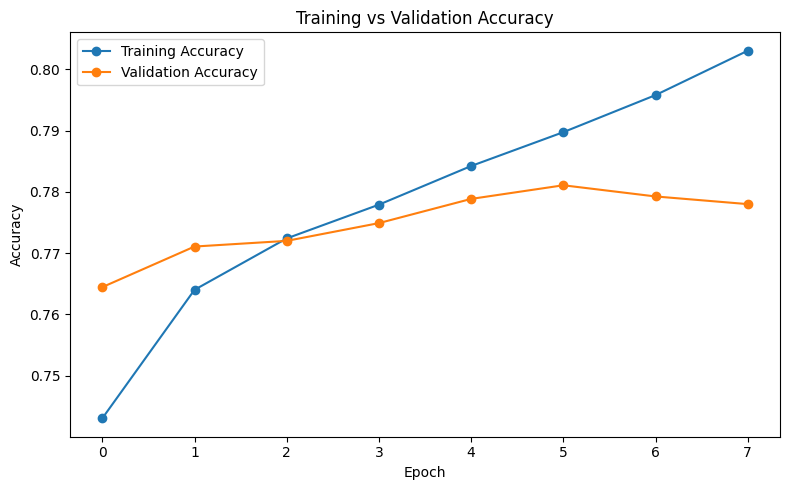

In [ ]:
plt.figure(figsize=(8, 5))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')

plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#(8) Evaluation of the Model
We evaluate the trained BiLSTM sentiment analysis model and compare its performance with two traditional lexicon-based approaches: TextBlob and VADER. TextBlob determines sentiment polarity scores and classifies positive values as positive sentiment, while VADER calculates compound sentiment scores and labels positive results as positive sentiment. As a result, we found our BiLSTM sentiment analysis model has significantly higher accuracy than that of TextBlob and VADER.

In [ ]:
# Evaluate model on the test data
test_loss, test_accuracy = model.evaluate(padded_test, y_test, verbose=1)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 118s 37ms/step - accuracy: 0.7797 - loss: 0.4661
Test Accuracy: 0.7791
Test Loss: 0.4667


In [ ]:
# Get predictions (rounded to either 0 or 1)
y_pred = (model.predict(padded_test) > 0.5).astype("int32")

# Print classification metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

In [ ]:
# Compare to the accuracy of TextBlob
def textblob_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    return 1 if polarity > 0 else 0

# Ensure 'cleaned_text' is a string
test_data['cleaned_text'] = test_data['cleaned_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Apply TextBlob sentiment function
test_data['textblob_pred'] = test_data['cleaned_text'].apply(textblob_sentiment)

# Calculate accuracy using TextBlob
accuracy = accuracy_score(test_data['sentiment'], test_data['textblob_pred'])
print("Accuracy of TextBlob:", accuracy)

In [ ]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define the function to calculate sentiment using VADER
def vader_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)  # Get sentiment scores
    if sentiment_score['compound'] > 0:  # Positive sentiment
        return 1
    else:  # Neutral or negative sentiment
        return 0

# Ensure 'cleaned_text' is a string
test_data['cleaned_text'] = test_data['cleaned_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Apply VADER sentiment function
test_data['vader_pred'] = test_data['cleaned_text'].apply(vader_sentiment)

# Calculate accuracy using Vader
accuracy = accuracy_score(test_data['sentiment'], test_data['vader_pred'])
print("Accuracy of Vader:", accuracy)

Accuracy of Vader: 0.63283


#(9) Save the Models and Tokenizer for Future Deployment
Finally, the model and tokenizer were saved for future use, which will be uploaded to Hugging Face for hosting [sentiment analysis application](https://huggingface.co/spaces/cckmwong/youtube_sentiment).

In [ ]:
# save the model
model.save('sentiment_lstm_model2.keras')

In [ ]:
# Save max_length
with open('max_length_sentiment2.txt', 'w') as f:
    f.write(str(max_length))

In [ ]:
# Save the tokenizer as JSON
tokenizer_json = tokenizer2.to_json()
with open('tokenizer_sentiment2.json', 'w') as f:
    f.write(tokenizer_json)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copy files to Drive
!cp sentiment_lstm_model2.keras /content/drive/MyDrive/
!cp max_length_sentiment2.txt /content/drive/MyDrive/
!cp tokenizer_sentiment2.json /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
